In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../environments/'); import gw
sys.path.insert(0,'../environments/'); import gridworld_plotting as gp
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec

import experiment as expt

#####
import torch
import time

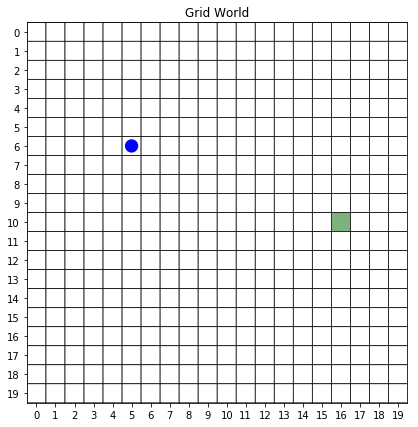

In [36]:
reload(gw)
rows, columns = 20, 20
env = gw.GridWorld(rows=rows,cols=columns,
                   rewards = {(10,16):1},#rewards={(int(rows/2),int(columns/2)):1},#
                   step_penalization=-0.01,
                   rho=0.0,
                   rewarded_action = None)
fig = gw.plotWorld(env,current_state=True,scale=0.35)


In [5]:
agent_params = {
    'load_model':  False,
    'load_dir':     f'../data/outputs/gridworld/openfield{rows}{columns}_r{list(env.rewards.keys())[0][0]}{list(env.rewards.keys())[0][1]}.pt',
    'freeze_w':    False,

    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','linear'],
    'hidden_dims': [None, None, 500],

    'rfsize':      5,
    'stride':      1,
    'padding':     1,
    'dilation':    1,

    'gamma':       0.98,
    'eta':         5e-4,

    'use_EC':      True,
    'EC':          {},
    'cachelim':    300,
    'mem_temp':    0.3
}
print(agent_params['load_dir'])

../data/outputs/gridworld/openfield2020_r103.pt


In [6]:
def run_expt(NUM_TRIALS, NUM_EVENTS, env, agent, data,
               **kwargs):
    
    print_freq  = kwargs.get('printfreq', 0.1)
    
    get_samples = kwargs.get('get_samples', False)
    if get_samples:
        sample_observations = env.get_sample_obs()
    
    around_reward = kwargs.get('around_reward', True)
    start_radius  = kwargs.get('radius', 5)
    
    t = time.time()
    for trial in range(NUM_TRIALS):
        # reset environment, reinitialize agent in environment
        env.resetEnvironment(around_rwd=around_reward, radius=start_radius)
        # clear hidden layer cache if using lstm or gru cells
        agent.reinit_hid()
        reward_sum = 0

        for event in range(NUM_EVENTS):
            #get state observation
            observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))

            #pass observation through network
            policy_, value_ = agent(observation)

            #select action from policy
            choice = agent.select_action(policy_, value_)
            action = env.action_list[choice][0]

            #take a step in the environment

            s_1d, reward, isdone = env.move(action)

            agent.saved_rewards.append(reward)
            reward_sum += reward
            ###optional
            #sar.append(env.state, action, reward) ## tracking oneD states
            if isdone:
                break

        p_loss, v_loss = agent.finish_trial()
        data['trial_length'].append(event)
        data['total_reward'].append(reward_sum)
        data['loss'][0].append(p_loss.item())
        data['loss'][1].append(v_loss.item())
        data['trials_run_to_date'] +=1
        if get_samples:
            pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
            data['pol_tracking'].append(pol_grid)
            data['val_tracking'].append(val_grid)
            data['t'].append(trial)
        
        if trial ==0 or trial % int(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1:
            print(f"{trial}: {reward_sum} ({time.time()-t}s)")
            t = time.time()

        if around_reward and trial > 0 and np.mean(data['trial_length'][-20:])< 2*start_radius:
            print(trial)
            data['full_map_trial'].append(trial)
            around_reward = False

In [30]:
def run_mem_expt(NUM_TRIALS, NUM_EVENTS, env, agent, episodic, data,
               **kwargs):
    
    print_freq  = kwargs.get('printfreq', 0.1)
    
    get_samples = kwargs.get('get_samples', False)
    if get_samples:
        sample_observations = env.get_sample_obs()
    
    around_reward = kwargs.get('around_reward', True)
    start_radius  = kwargs.get('radius', 5)
    
    episodic.reset_cache() ##NEW
    ploss_scale = 0 ##NEW
    mfc_env     = ec.calc_env(halfmax = 3.12) ##NEW
    recency_env = ec.calc_env(halfmax = 20) ##NEW
    mem_entropy = kwargs.get('mem_entropy', 0.3) ##NEW
    timestamp   = 0 ##NEW
    
    t = time.time()
    for trial in range(NUM_TRIALS):
        # reset environment, reinitialize agent in environment
        env.resetEnvironment(around_rwd=around_reward, radius=start_radius)
        # clear hidden layer cache if using lstm or gru cells
        agent.reinit_hid()
        reward_sum = 0
        
        MF_confidence = episodic.make_pvals(ploss_scale, envelope=mfc_env) ##NEW
        memory_buffer = [[],[],[],[], trial] ##NEW

        for event in range(NUM_EVENTS):
            #get state observation
            observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))

            #pass observation through network
            policy_, value_, lin_act_ = agent(observation, lin_act = 2)
            lin_act = tuple(np.round(lin_act_.data[0].numpy(), 4)) ##NEW
            
            #choose which policy to use based on MF confidence
            which_pol = np.random.choice(['MF', 'EC'], p = [MF_confidence, 1-MF_confidence])
            if which_pol == 'EC':
                memory_policy = torch.from_numpy(episodic.recall_mem(lin_act, 
                                                               timestamp, 
                                                               env=recency_env, 
                                                               mem_temp=mem_entropy))
                choice = agent.select_ec_action(policy_, value_, memory_policy)
            
            else:
                #select action from policy
                choice = agent.select_action(policy_, value_)

            action = env.action_list[choice][0]
            
            memory_buffer[0].append(timestamp)
            memory_buffer[1].append(lin_act)
            memory_buffer[2].append(choice)
            memory_buffer[3].append(env.oneD2twoD(env.state))
            
            #take a step in the environment
            s_1d, reward, isdone = env.move(action)

            agent.saved_rewards.append(reward)
            reward_sum += reward
            
            timestamp += 1
            
            if isdone:
                break

        p_loss, v_loss = agent.finish_trial_EC(cache=episodic, buffer=memory_buffer)
        
        data['trial_length'].append(event)
        data['total_reward'].append(reward_sum)
        data['loss'][0].append(p_loss.item())
        data['loss'][1].append(v_loss.item())
        data['trials_run_to_date'] +=1
        if get_samples:
            pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
            mem_grid = ac.mem_snapshot(env,episodic_memory,trial_timestamp = trial,
                                   decay = recency_env, mem_temp = mem_entropy, get_vals= False)
            data['ec_tracking'].append(mem_grid)
            data['pol_tracking'].append(pol_grid)
            data['val_tracking'].append(val_grid)
            data['t'].append(trial)
        
        if trial ==0 or trial % int(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1:
            print(f"{trial}: {reward_sum} ({time.time()-t}s)")
            t = time.time()

        if around_reward and trial > 0 and np.mean(data['trial_length'][-20:])< 2*start_radius:
            print(trial)
            data['full_map_trial'].append(trial)
            around_reward = False

In [31]:
rerun = True
NUM_TRIALS = 5000
NUM_EVENTS = 300
if not rerun:
    agent = ac.make_agent(agent_params)
    data = {'total_reward': [],
            'loss': [[],[]],
            'trial_length': [],
            'trials_run_to_date':0,
            'pol_tracking':[],
            'val_tracking':[],
            'ec_tracking': [],
            't': [],
            'full_map_trial': []
           }


#run_expt(NUM_TRIALS, NUM_EVENTS, env, agent, data, get_samples=True, printfreq = 0.01)

In [37]:
#reload(ec)
#episodic_memory = ec.ep_mem(agent, 300)
run_mem_expt(NUM_TRIALS, NUM_EVENTS, env, agent, episodic_memory, data, get_samples=True, printfreq=0.01)

0: -2.99999999999998 (0.44365358352661133s)
50: -2.99999999999998 (22.39472484588623s)
100: 0.97 (21.27407193183899s)
150: -2.99999999999998 (20.342023611068726s)
200: -2.99999999999998 (20.9177143573761s)
250: 0.98 (19.31300973892212s)
300: -2.99999999999998 (20.896469593048096s)
350: 0.5699999999999998 (15.47310185432434s)
400: -2.99999999999998 (15.581135034561157s)
450: -2.99999999999998 (12.870881795883179s)
500: 0.94 (11.626853942871094s)
550: 0.97 (12.368452310562134s)
600: -2.99999999999998 (13.78244423866272s)
650: -2.99999999999998 (14.105616569519043s)
700: -2.99999999999998 (10.05590009689331s)
750: -2.99999999999998 (12.77377700805664s)
800: 0.87 (11.397268295288086s)
850: 0.99 (7.7265684604644775s)
868
900: -2.99999999999998 (12.695719242095947s)
950: -2.99999999999998 (16.26985263824463s)
1000: -2.99999999999998 (18.716938018798828s)
1050: -2.99999999999998 (18.121651887893677s)
1100: -2.99999999999998 (17.740865468978882s)
1150: 0.89 (13.555938720703125s)
1200: -2.99999

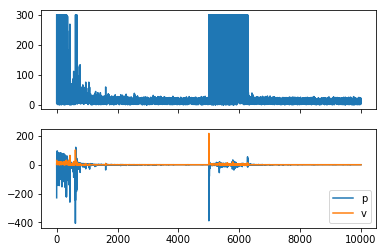

In [38]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(data['trial_length'])
ax[1].plot(data['loss'][0], label='p')
ax[1].plot(data['loss'][1], label='v')
ax[1].legend(loc=0)
plt.show()
#plt.savefig('./Blake Meeting/Total_reward.svg', format='svg')

In [ ]:
reload(gp)
sample_observations = env.get_sample_obs()
pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
valmin = np.floor(np.min(val_grid))
valmax = np.ceil(np.max(val_grid))

gp.plot_polmap(env, pol_grid, threshold = 0.22, save=False, directory = './Blake Meeting/', title='p_after reward switch 7500', filetype='svg')
gp.plot_valmap(env, val_grid, v_range = [-0.5,1], save=False, directory = './Blake Meeting/', title='v_after reward switch 7500', filetype='svg')

In [39]:
import pickle
pickle.dump(data, open('./Blake Meeting/simple_network/MF_EC.p', 'wb'))

In [40]:
ac.torch.save(agent,agent_params['load_dir'])

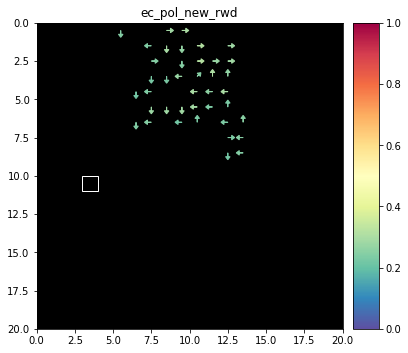

In [26]:
abcd, efgh = ac.mem_snapshot(env, 
                       episodic_memory, 
                       trial_timestamp = 410, 
                       decay           = ec.calc_env(halfmax = 20), 
                       mem_temp        = 0.3,
                            get_vals=True)#agent_params['mem_temp'])
gp.plot_polmap(env, abcd,save=False, threshold = 0.22, title='ec_pol_new_rwd')

In [ ]:
print(env.state, oneD2twoD(env.state, env.shape))
fig = plotWorld(env,current_state=False)

num_steps = 10
moves = True
if moves:
    for _ in range(num_steps):
        if _ == 0:
            action_choice = ""
        start_at = oneD2twoD(env.state, env.shape)
        # draw state
        agent_y, agent_x = oneD2twoD(env.state, env.shape)
        agent_dot = plt.Circle((agent_x + .5, agent_y + .5), 0.35, fc='b')
        fig.gca().add_artist(agent_dot)

        # select action
        action_choice = random_policy(env)
        env.move(action_choice)

        print(f"{start_at}:{action_choice} --> {oneD2twoD(env.state, env.shape)}")
        text = plt.gcf().text(0.1, 0.9, f'Agent Chooses: {action_choice}', fontsize=14)

        plt.pause(1)
        plt.draw()
        dx1, dy1, head_w, head_l = make_arrows(env.action_dict[action_choice])
        if action_choice == 'P':
            arrow = plt.text(agent_x+0.49, agent_y+0.6, "*", {'color': 'white', 'fontsize': 24, 'ha': 'center', 'va': 'center'})
        else:
            arrow = plt.arrow(agent_x+0.5, agent_y+0.5, dx1, dy1, head_width=0.3, head_length=0.2, color="cyan")


        plt.pause(.5)
        plt.draw()

        if _ < num_steps-1:
            agent_dot.remove()
            arrow.remove()
            text.remove()
plt.show()